## Stationarity

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import  statsmodels.tsa.api as tsa # new import
from sklearn import set_config
#set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)
# set random seed
SEED = 321
np.random.seed(SEED)

In [2]:
# Calculating a simulated white noise time series (one value)
c = 49
noise_t = np.random.normal()
# Add the random value to the mean to get the duration of the lap for one day
y_t= c + noise_t
y_t

49.17251946894025

In [3]:
# Calculating a simulated white noise time series for 120 days
c = 49
n_lags = 120
y = []
for t in range(n_lags):
    
    noise_t = np.random.normal(size=1)
    y_t = c + noise_t[0] # slicing 0 to get value instead of arrays
    y.append(y_t)

In [7]:
# convert y from list to series (1-dimensional list) named ts_white_noise
ts_white_noise = pd.Series(y, name='Simulated White Noise')     
ts_white_noise

0      50.635483
1      49.037336
2      48.115850
3      47.856808
4      48.378634
         ...    
115    50.081623
116    49.227369
117    50.421600
118    48.683405
119    47.880499
Name: Simulated White Noise, Length: 120, dtype: float64

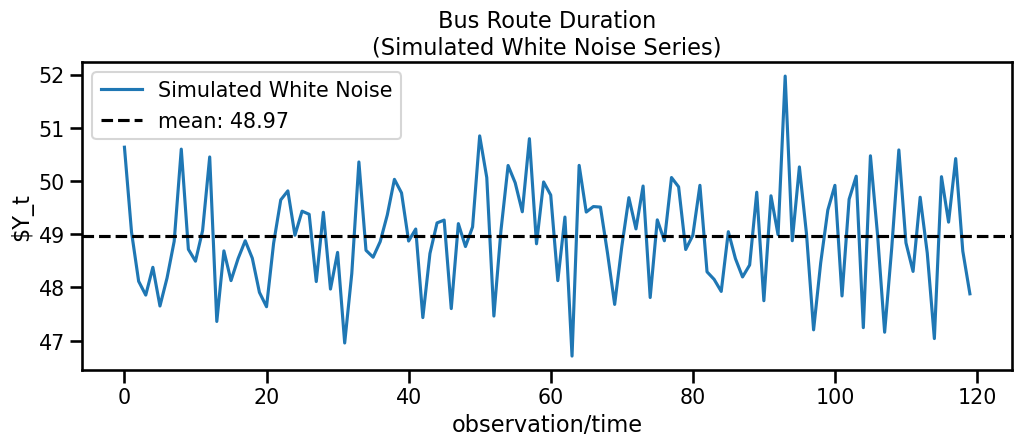

In [12]:
# Plotting the white noise series with annotated mean
ax = ts_white_noise.plot()
ax.set(title='Bus Route Duration\n(Simulated White Noise Series)',
       ylabel='$Y_t', xlabel='observation/time');
ax.axhline( ts_white_noise.mean(),  color='k', ls='--',
           label=f'mean: {ts_white_noise.mean():.2f}');
ax.legend();

In [13]:
# Running the adfuller test to demonstrate return
tsa.adfuller(ts_white_noise)

(-11.133859534698885,
 3.2317307055656125e-20,
 0,
 119,
 {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057},
 295.21163114049114)

In [14]:
# Saving each output separately
(test_stat, pval, nlags, nobs, crit_vals_d, icbest) = tsa.adfuller(ts_white_noise)

In [16]:
# Saving the most important results as a dictionary
adfuller_results = {'Test Statistic': test_stat,
                    "# of Lags Used":nlags, 
                   '# of Observations':nobs,
                    'p-value': round(pval,6)}


In [17]:
# Adding interpretation of p-value to dictionary
alpha =.05
adfuller_results['sig/stationary?'] = pval < alpha
adfuller_results

{'Test Statistic': -11.133859534698885,
 '# of Lags Used': 0,
 '# of Observations': 119,
 'p-value': 0.0,
 'sig/stationary?': True}

In [18]:
# Convert dictionary of results to a dataframe
adfuller_df = pd.DataFrame(adfuller_results, index=['AD Fuller Test'])
adfuller_df

,Test Statistic,# of Lags Used,# of Observations,p-value,sig/stationary?
AD Fuller Test,-11.13386,0,119,0.0,True


In [19]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [20]:
# Testing the function
adfuller_results = get_adfuller_results(ts_white_noise, label='White Noise')
adfuller_results

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
White Noise,-11.13386,0,119,0.0,0.05,True


## Autocorrelation

In [21]:
# Shift the data one step 
ts_lag1 = ts_white_noise.shift(1)
ts_lag1 = ts_lag1.rename('Lag 1')
ts_lag1.head()

0          NaN
1    50.635483
2    49.037336
3    48.115850
4    47.856808
Name: Lag 1, dtype: float64

In [22]:
# Combine original ts + with lag 1
ts_lagged = pd.concat([ts_white_noise,ts_lag1], axis=1)
ts_lagged.head()

,Simulated White Noise,Lag 1
0,50.635483,NaN
1,49.037336,50.635483
2,48.115850,49.037336
3,47.856808,48.115850
4,48.378634,47.856808


In [23]:
# Checking for correlation
ts_lagged.corr()

,Simulated White Noise,Lag 1
Simulated White Noise,1.000000,-0.021783
Lag 1,-0.021783,1.000000


In [24]:
# Generate 20 time-shifted columns
ts_lagged = pd.DataFrame()
total_shifts = 20
for t in range(0,total_shifts+1):    
    ts_lagged[f"Lag {t}"] =  ts_white_noise.shift(t)
ts_lagged.head()

,Lag 0,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,...,Lag 11,Lag 12,Lag 13,Lag 14,Lag 15,Lag 16,Lag 17,Lag 18,Lag 19,Lag 20
0,50.635483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49.037336,50.635483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48.115850,49.037336,50.635483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,47.856808,48.115850,49.037336,50.635483,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48.378634,47.856808,48.115850,49.037336,50.635483,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Calculate correlations for all values
corr = ts_lagged.corr()
corr.head()

,Lag 0,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,...,Lag 11,Lag 12,Lag 13,Lag 14,Lag 15,Lag 16,Lag 17,Lag 18,Lag 19,Lag 20
Lag 0,1.000000,-0.021783,-0.064080,-0.018734,-0.014180,-0.118503,0.018079,0.064780,-0.173773,-0.128825,...,0.058375,0.038630,-0.037089,0.075861,0.021654,0.175557,0.166579,-0.028704,-0.282454,-0.125067
Lag 1,-0.021783,1.000000,-0.024832,-0.050657,-0.016234,-0.002859,-0.141524,0.014664,0.073168,-0.182525,...,0.142978,0.056308,0.019034,-0.037182,0.094835,0.001457,0.191472,0.176576,-0.043111,-0.274006
Lag 2,-0.064080,-0.024832,1.000000,-0.021312,-0.050016,-0.013321,-0.008398,-0.142619,0.016912,0.071255,...,-0.127894,0.142397,0.051440,0.019082,-0.032922,0.090528,0.005322,0.194548,0.173809,-0.039859
Lag 3,-0.018734,-0.050657,-0.021312,1.000000,-0.025063,-0.066142,0.013100,-0.003901,-0.154446,0.026492,...,-0.210015,-0.126081,0.172880,0.051795,-0.002686,-0.007229,0.074885,-0.005278,0.215711,0.161757
Lag 4,-0.014180,-0.016234,-0.050016,-0.025063,1.000000,-0.028093,-0.062291,0.013955,-0.005708,-0.153189,...,0.071136,-0.209615,-0.123666,0.172903,0.048696,0.001656,-0.010319,0.073314,-0.002383,0.214486


In [27]:
# Slice out the original ts (lag 0) to check for lags correlated to the original value
auto_corr = corr['Lag 0']
auto_corr

Lag 0     1.000000
Lag 1    -0.021783
Lag 2    -0.064080
Lag 3    -0.018734
Lag 4    -0.014180
Lag 5    -0.118503
Lag 6     0.018079
Lag 7     0.064780
Lag 8    -0.173773
Lag 9    -0.128825
Lag 10    0.122801
Lag 11    0.058375
Lag 12    0.038630
Lag 13   -0.037089
Lag 14    0.075861
Lag 15    0.021654
Lag 16    0.175557
Lag 17    0.166579
Lag 18   -0.028704
Lag 19   -0.282454
Lag 20   -0.125067
Name: Lag 0, dtype: float64

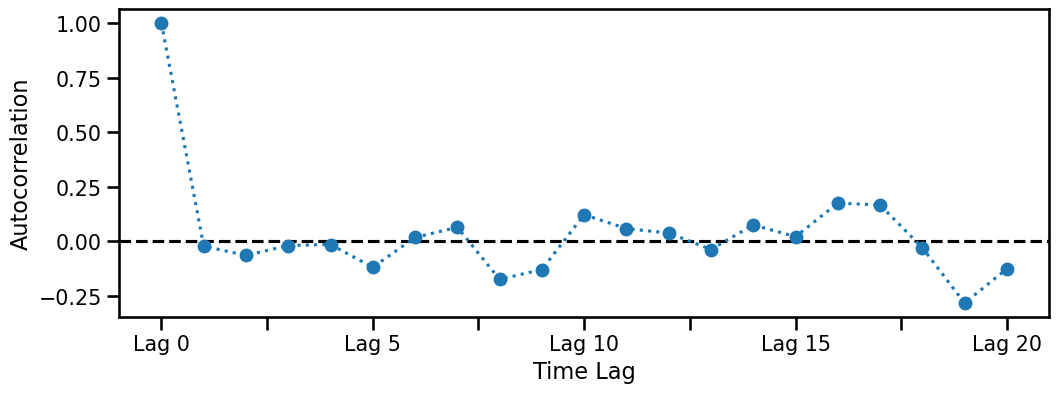

In [28]:
# Plot the calculated correlations
ax = auto_corr.plot(style='o:')
ax.axhline(0, color='k', ls='--', zorder=-1);
ax.set(ylabel='Autocorrelation', xlabel='Time Lag');

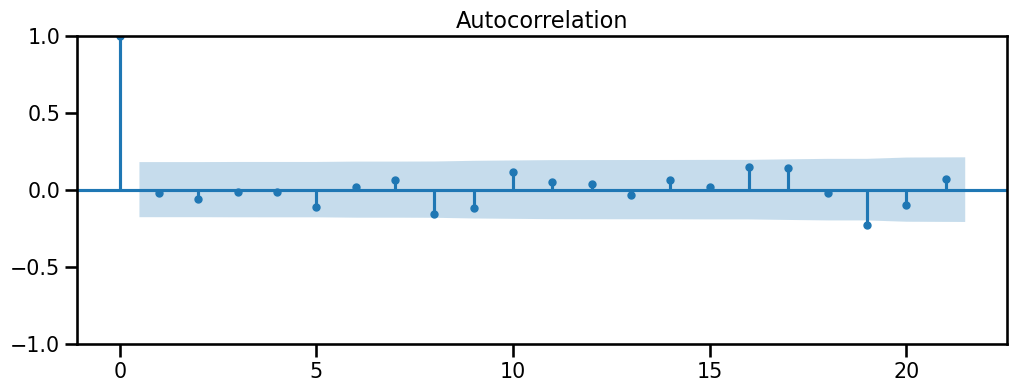

In [29]:
# plot same data above with built in function plot_acf
# if markers stay mostly within shaded region, then there is not autocorrelation
fig = tsa.graphics.plot_acf(ts_white_noise);

## Random Walk Time Series

Random walks are Not stationary.

Random walks have significant Autocorrelation.

Differencing a random walk time series creates a white-noise time series.

### Create simulated Random Walk Time Series

In [30]:
# Calculating a simulated random walk 
first_t = 150
y_walk = [first_t]
n_lags=120
for t in range(1,n_lags):
    # get the previous time lag's value
    y_prev_t = y_walk[t-1]
    
    # Get new noise
    noise_t = np.random.normal(size=1)
    
    # Add noise on to previous value
    y_t = y_prev_t + noise_t[0] # slicing 0 to get value instead of arrays
    y_walk.append(y_t)
    
ts_rand_walk = pd.Series(y_walk, name='Simulated Random Walk')    
ts_rand_walk

0      150.000000
1      148.598865
2      147.131094
3      148.014590
4      147.161973
          ...    
115    153.871576
116    152.788941
117    153.142111
118    155.103555
119    155.816590
Name: Simulated Random Walk, Length: 120, dtype: float64

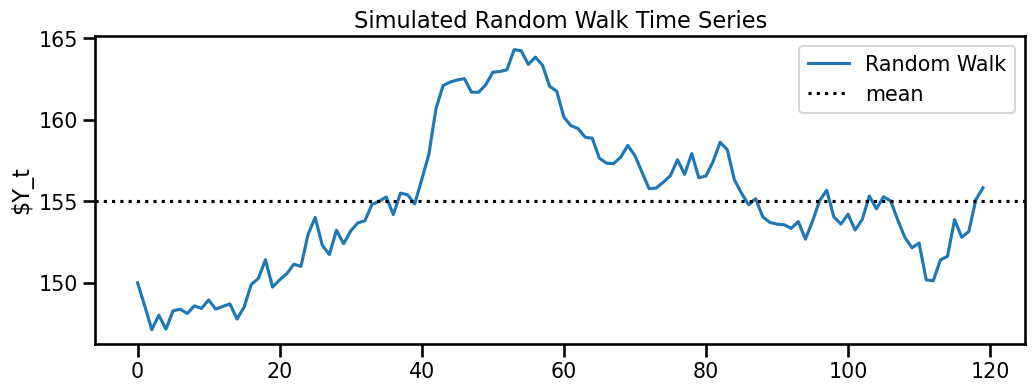

In [32]:
# Visualize the random walk time series
ax = ts_rand_walk.plot(label='Random Walk')
ax.set(ylabel='$Y_t', title='Simulated Random Walk Time Series');
ax.axhline(ts_rand_walk.mean(), color='black', ls=':', label='mean');
ax.legend();

In [33]:
# Test random walk forstationarity
get_adfuller_results(ts_rand_walk)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.442588,0,119,0.561697,0.05,False


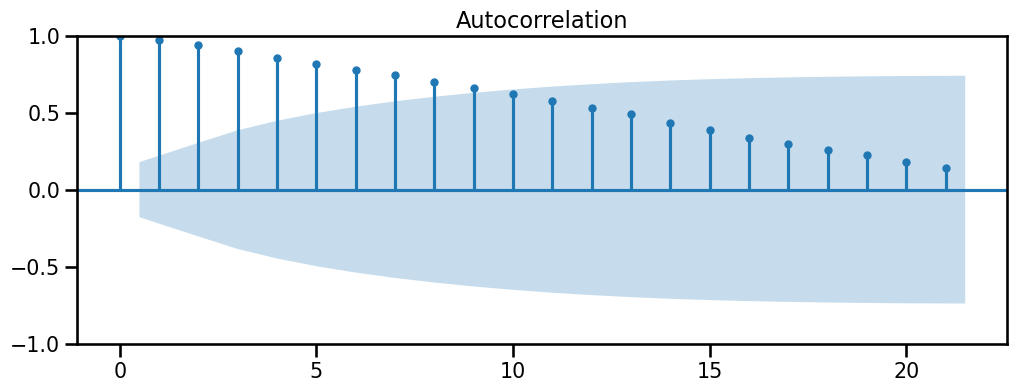

In [34]:
# Check for autocorrelation
tsa.graphics.plot_acf(ts_rand_walk);

In [35]:
# Orignal random walk
ts_rand_walk.head()

0    150.000000
1    148.598865
2    147.131094
3    148.014590
4    147.161973
Name: Simulated Random Walk, dtype: float64

In [36]:
# Differenced random walk
ts_rand_walk.diff().head()

0         NaN
1   -1.401135
2   -1.467771
3    0.883495
4   -0.852617
Name: Simulated Random Walk, dtype: float64

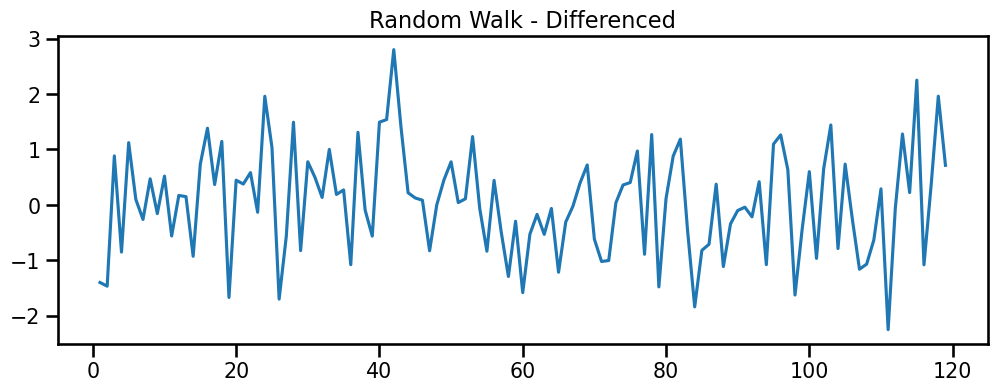

In [37]:
# Plot the differenced random walk
ts_rand_walk_diff = ts_rand_walk.diff().dropna()
ts_rand_walk_diff.plot(title='Random Walk - Differenced');

In [38]:
# Test differenced random walk for stationarity
get_adfuller_results(ts_rand_walk_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-10.109419,0,118,0.0,0.05,True


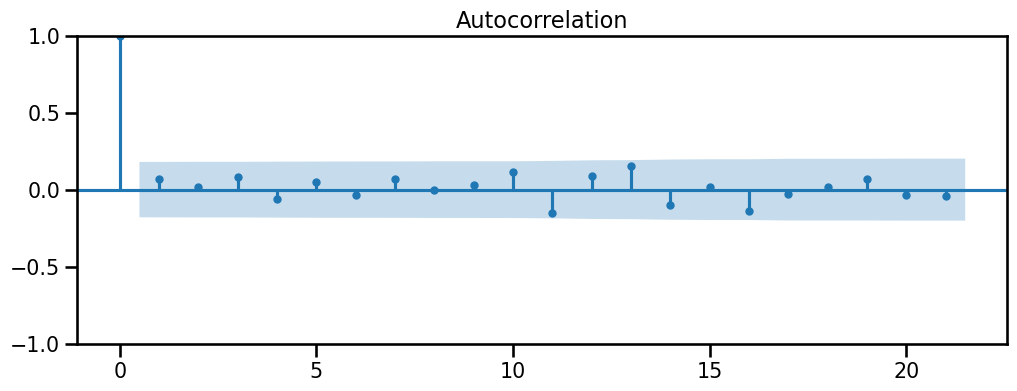

In [41]:
# Check differenced random walk for autocorrelation
tsa.graphics.plot_acf(ts_rand_walk_diff);

### Random Walk with a Drift

Random walks with a drift are Not stationary.

Random walks with a drift have significant Autocorrelation.

Random walks with a drift have a constant trend (increase or decrease).

Differencing a random walk with a drift time series creates a stationary time series.

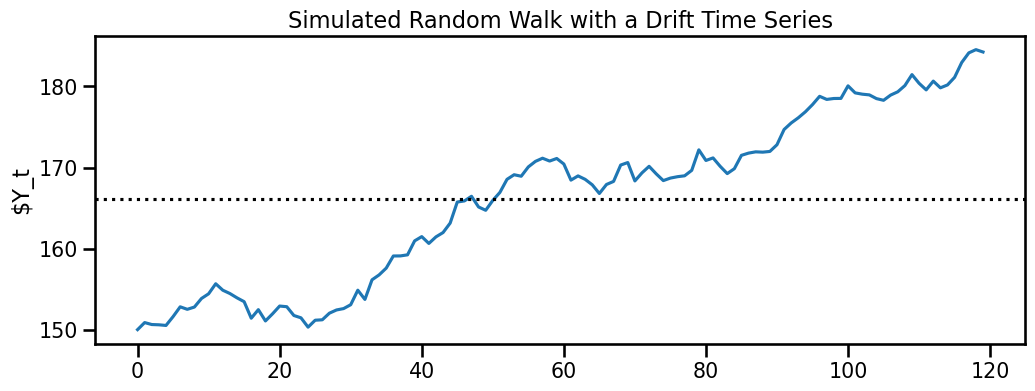

In [43]:
# Creating simulated random walk with a drift
first_t = 150
c = .3
y_walk_drift = [first_t]
for t in range(1,n_lags):
    # get the previous time lag's value
    y_prev_t = y_walk_drift[t-1]
    
    # Get new noise
    noise_t = np.random.normal(size=1)
    # Add noise on to previous value
    y_t = c + y_prev_t + noise_t[0]# slicing 0 to get value instead of arrays
    y_walk_drift.append(y_t)
    
ts_rand_walk_drift = pd.Series(y_walk_drift, name = "Simulated Random walk (+dift)")    
ax = ts_rand_walk_drift.plot()
ax.set(ylabel='$Y_t', title='Simulated Random Walk with a Drift Time Series');
ax.axhline(ts_rand_walk_drift.mean(), color='black', ls=':');

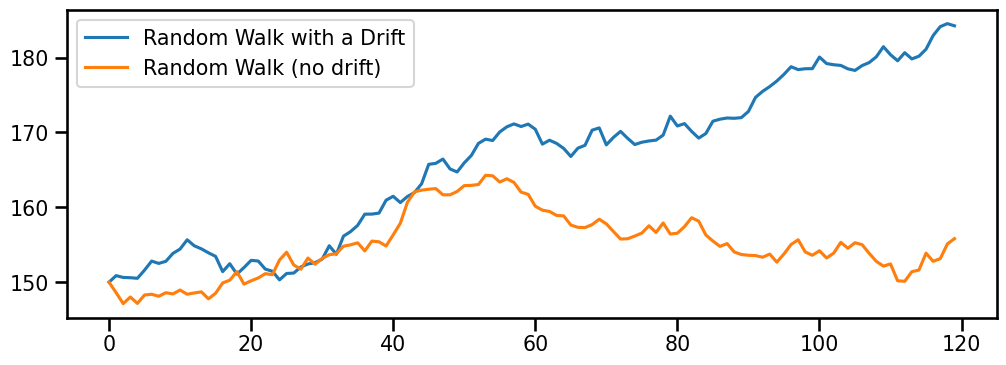

In [44]:
# compare random walk with a drift vs without
ax = ts_rand_walk_drift.plot(label='Random Walk with a Drift')
ts_rand_walk.plot(ax=ax, label='Random Walk (no drift)')
ax.legend();

In [45]:
# Test random walk with a drift for stationarity
get_adfuller_results(ts_rand_walk_drift)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-0.189886,0,119,0.939716,0.05,False


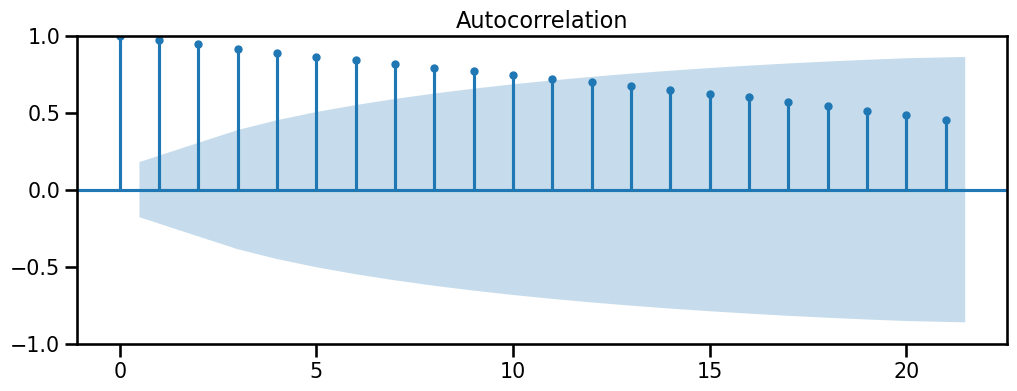

In [46]:
# Test random walk a with a drift for autocorrelation
tsa.graphics.plot_acf(ts_rand_walk_drift);

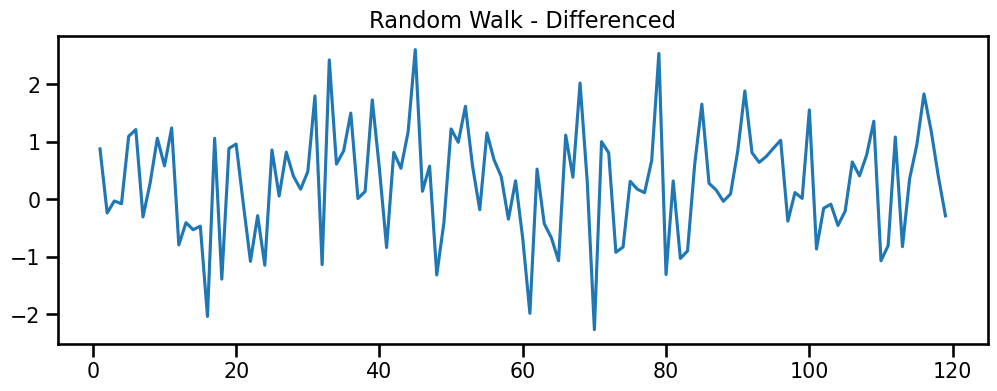

In [47]:
# Difference the random walk with a drift
ts_rand_walk_drift_diff = ts_rand_walk_drift.diff().dropna()
# Visualize the differenced random walk with a drift
ts_rand_walk_drift_diff.plot(title='Random Walk - Differenced');

In [48]:
# Confirm that a differenced random walk with drift is stationary
get_adfuller_results(ts_rand_walk_drift_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-10.45481,0,118,0.0,0.05,True


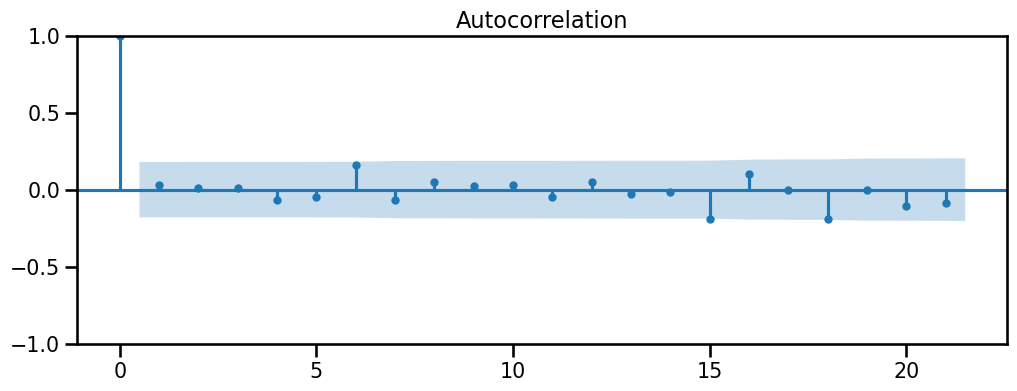

In [50]:
# Check the differenced random walk with drift for autocorrelation
tsa.graphics.plot_acf(ts_rand_walk_drift_diff);

## AR Models

AR models are designed to create a linear regression for time series.

In time series models, the target, y, is also used to generate the time-lagged features ).

AR models create a linear model that includes a constant and a new type of time-lag coefficient, which we represent with the Greek symbol, phi.

In [51]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

In [52]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [53]:
# load data
ts = pd.read_csv('Data/AR_lesson_ts.csv')

# preview data
ts.head()

,date,dollars
0,2020-01-05,0.422207
1,2020-01-12,-0.455290
2,2020-01-19,0.914767
3,2020-01-26,0.562761
4,2020-02-02,-0.649239


In [60]:
# Make index datetime
ts.index = pd.to_datetime(ts['date'])

In [62]:
# We have weekly data so we will set our frequency to W
ts.index.freq= "W"

In [63]:
# Make a series
ts = ts['dollars']

In [67]:
# Check for nulls
ts.isna().sum().sum()

0

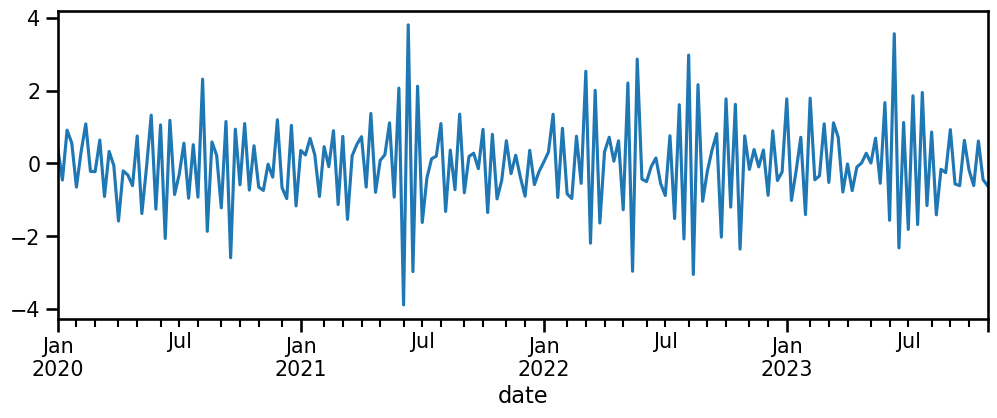

In [68]:
# Plot the time series
ts.plot();

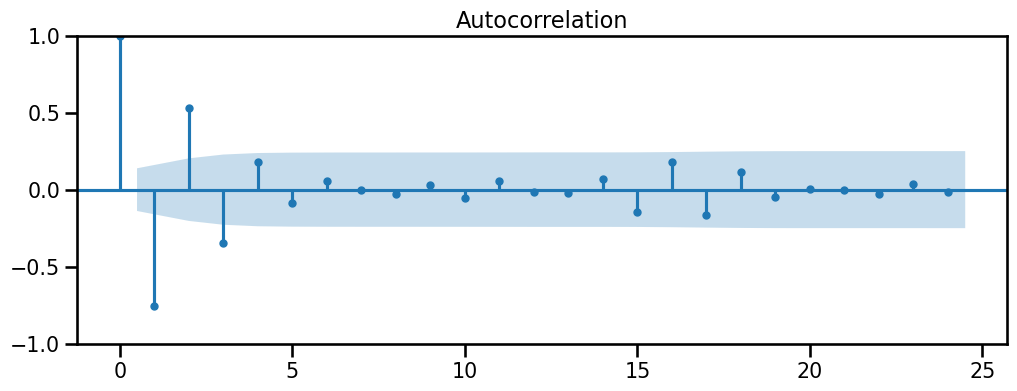

In [69]:
# Make acf plot of raw data to look for seasonality
tsa.graphics.plot_acf(ts);

In [70]:
# Call custom function to check to see if data is stationary
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-14.612186,1,198,0.0,0.05,True


In [72]:
from pmdarima.arima.utils import ndiffs
# use ndiffs to determine differencing needs ('d' is times needed to be diff'ed to be stationary)
# if d = 0 then already stationary

d = ndiffs(ts)
print(f'd is {d}')

d is 0


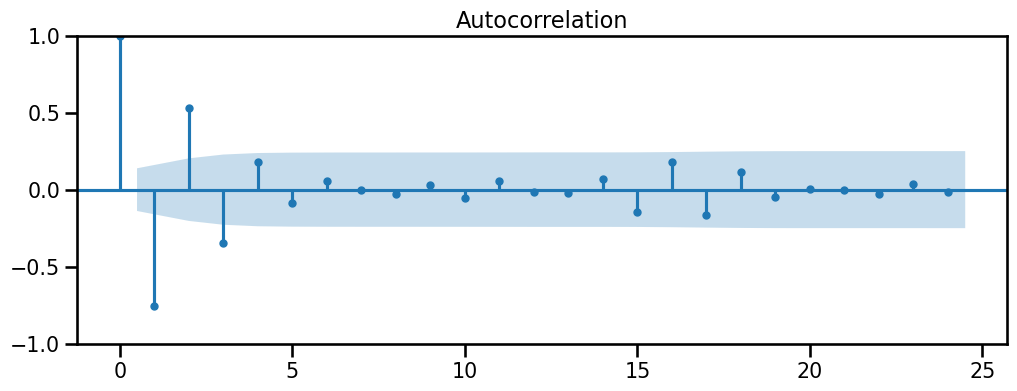

In [73]:
# Make acf plot to determine if this is AR or MA 
tsa.graphics.plot_acf(ts);

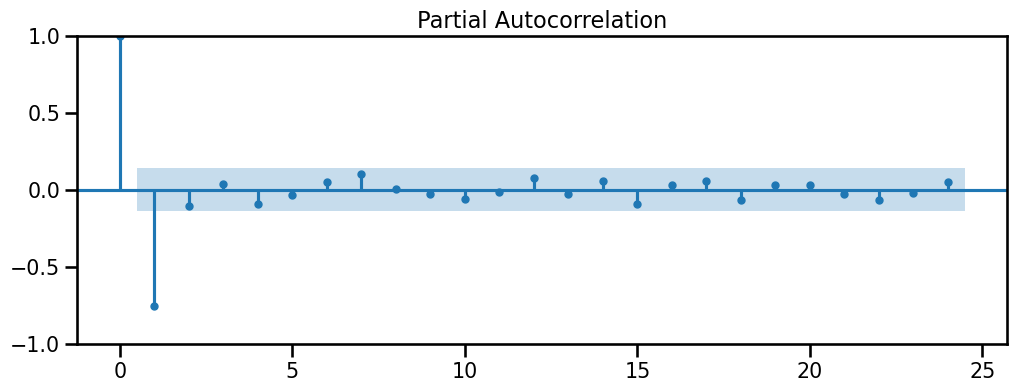

In [74]:
# Examine the PACF plot to determine order of AR model
tsa.graphics.plot_pacf(ts);

### Validation Split

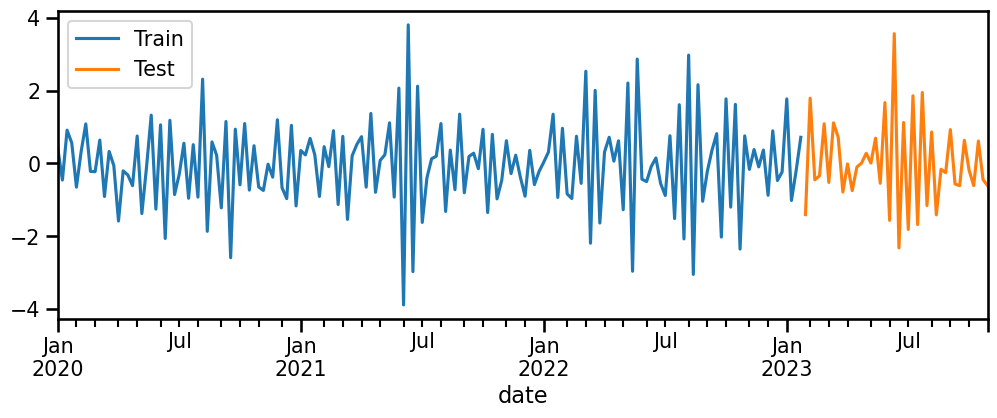

In [75]:
from pmdarima.model_selection import train_test_split
# tts
train, test = train_test_split(ts, test_size=.20)
# Visualize the train and test data
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

#### Statsmodels

In [76]:
# proper way to import tsa submodule
import statsmodels.tsa.api as tsa

In [79]:
# First define the orders (p,d,q)
p = 1 # AR(1) model based on significant lags in PACF
d = 0 # No differcing needed to make stationary
q = 0 # q will be used for MA models (set to 0 for an AR only model)
# Now instantiate the model with the data and fit
ar_1_model = tsa.ARIMA(train, order = (p,d,q)).fit()
ar_1_model

In [80]:
# Obtain the parameters of the fit model
ar_1_model.params

const    -0.033178
ar.L1    -0.754862
sigma2    0.626342
dtype: float64

In [83]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = ar_1_model.get_forecast(steps=len(test)).summary_frame()
forecast_df.head()

dollars,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-29,-0.600555,0.791418,-2.151706,0.950595
2023-02-05,0.395113,0.991585,-1.548359,2.338585
2023-02-12,-0.356479,1.089316,-2.491499,1.778541
2023-02-19,0.210869,1.141267,-2.025974,2.447712
2023-02-26,-0.217400,1.169839,-2.510242,2.075441


In [84]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax



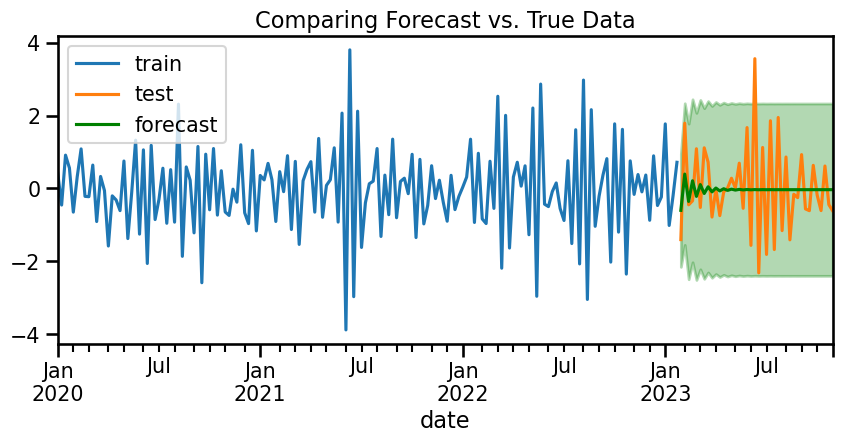

In [85]:
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);

### Model Evaluation